# Initial convolutional neural network.

## This is just an example with small amount of images training a model. Obviously, the accuracy is low.

In [2]:
reset -fs

In [3]:
import numpy as np
import pandas as pd
import os
import glob
import pickle
import gzip
import dl_functions
from IPython.display import display
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from skimage import io, color, exposure, transform
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.cross_validation import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


#### Number of images to pre-process per class.

In [4]:
NUMBER_IMAGES = 1000

#### Images we will resized as specified below.

In [5]:
IMG_SIZE = 250

#### Directory where images from epicurious.com will be downloaded.

In [6]:
ok_images='data/downloads/ok'

#### Directory where images from food.com will be downloaded.

In [7]:
nok_images='data/downloads/nok'

#### Creating an array of images already pre-processed and ready to fit a model. Array is normalized.

First, OK images.

In [8]:
i = 1
imgs = []
dirPath = ok_images
fileList = os.listdir(dirPath)
for fileName in fileList:
    if i < (NUMBER_IMAGES + 1):
        img = load_img(dirPath + '/' + fileName)
        img_reshape = img.resize((IMG_SIZE, IMG_SIZE))
        img_array = img_to_array(img_reshape)
        imgs.append(img_array)
        i += 1
  
X_ok = np.array(imgs, dtype='float32')/255.

Then, NOK images.

In [9]:
i = 1
imgs = []
dirPath = nok_images
fileList = os.listdir(dirPath)
for fileName in fileList:
    if i < (NUMBER_IMAGES + 1):
        img = load_img(dirPath + '/' + fileName)
        img_reshape = img.resize((IMG_SIZE, IMG_SIZE))
        img_array = img_to_array(img_reshape)
        imgs.append(img_array)
        i += 1
  
X_nok = np.array(imgs, dtype='float32')/255.

#### Note that we stack first the 'good' images, then the 'bad' ones.

In [10]:
X = np.vstack((X_ok , X_nok))

#### Creating an array of labels.
Label 1 indicates good image, and 0 bad image. Note that half of the images are good, half are bad, so labels are calculated accordingly.

In [11]:
y = np.vstack((np.array([1]*(len(X)/2)).reshape((len(X)/2), 1), np.array([0]*(len(X)/2)).reshape((len(X)/2), 1)))

#### Creating a train, test split.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### The labels need to be converted to categorical. Note that we have 2 categories: good (1) and bad (0) images.

In [13]:
y_train_sparse = np_utils.to_categorical(y_train, 2)

In [14]:
y_test_sparse = np_utils.to_categorical(y_test, 2)

#### Creating an instance of a CNN model.

In [15]:
model_1 = dl_functions.cnn_model_v_1(IMG_SIZE)

In [16]:
model_1.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [17]:
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 248, 248, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 122, 122, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 59, 59, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 29, 29, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 53824)             0         
__________

In [18]:
model_1.fit(X_train, y_train_sparse, batch_size=128, epochs=20, verbose=1, validation_split=0.3)

Train on 979 samples, validate on 421 samples
Epoch 1/20
979/979 [==============================] - 472s - loss: 6.7041 - acc: 0.5169 - val_loss: 8.8338 - val_acc: 0.4489
Epoch 2/20
979/979 [==============================] - 349s - loss: 7.7160 - acc: 0.5169 - val_loss: 8.8338 - val_acc: 0.4489
Epoch 3/20
979/979 [==============================] - 398s - loss: 7.7733 - acc: 0.5138 - val_loss: 8.8338 - val_acc: 0.4489
Epoch 4/20
979/979 [==============================] - 361s - loss: 7.8112 - acc: 0.5117 - val_loss: 8.8338 - val_acc: 0.4489
Epoch 5/20
979/979 [==============================] - 380s - loss: 7.7666 - acc: 0.5107 - val_loss: 8.8338 - val_acc: 0.4489
Epoch 6/20
979/979 [==============================] - 371s - loss: 7.7494 - acc: 0.5148 - val_loss: 8.8338 - val_acc: 0.4489
Epoch 7/20
979/979 [==============================] - 372s - loss: 7.6415 - acc: 0.5199 - val_loss: 8.8338 - val_acc: 0.4489
Epoch 8/20
979/979 [==============================] - 400s - loss: 7.6816 - acc

In [19]:
score = model_1.evaluate(X_test, y_test_sparse, verbose=1)

600/600 [==============================] - 103s   


In [20]:
print('Test loss: {:0,.4f}'.format(score[0]))
print('Test accuracy: {:.2%}'.format(score[1]))

Test loss: 7.9617
Test accuracy: 50.33%


#### Creating a list of predictions.

In [21]:
predicted_images = []
for i in model_1.predict(X_test):
    predicted_images.append(np.where(np.max(i) == i)[0])

#### Displaying a confusion matrix.

dl_functions.py:259: RuntimeWarning: invalid value encountered in divide
  'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),


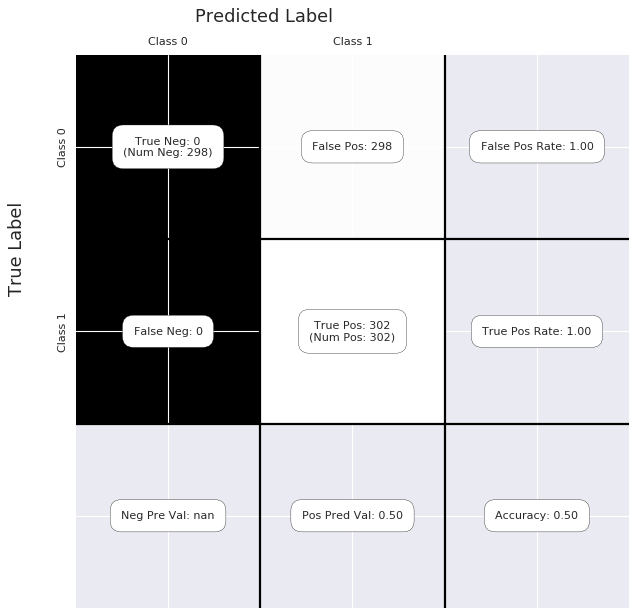

In [22]:
dl_functions.show_confusion_matrix(confusion_matrix(y_test, predicted_images), ['Class 0', 'Class 1'])

In [23]:
pd.DataFrame(confusion_matrix(y_test, predicted_images),columns = ['nok_image','ok_image'])

,nok_image,ok_image
0,0,298
1,0,302


In [24]:
predictions_probability = model_1.predict_proba(X_test)

600/600 [==============================] - 38s    


#### Plotting a ROC curve.

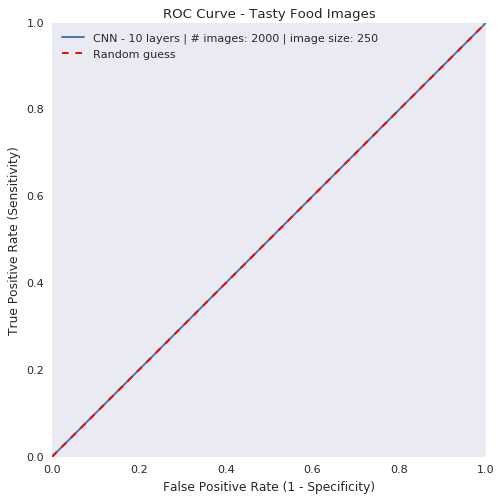

In [26]:
plt.figure(figsize=(7, 7))
dl_functions.plot_roc(y_test, predictions_probability[:,1], "CNN - " + str(len(model_1.layers)) + " layers | # images: " + str(len(X)) + " | image size: " + str(IMG_SIZE), "Tasty Food Images")

### Prediction using an image of Donald Trump.
<img src='images/trump_1.jpg'/>

In [27]:
trump = dl_functions.normalize_images_array('images', IMG_SIZE)

In [28]:
trump_prediction = model_1.predict_classes(trump)

1/1 [==============================] - 0s


In [29]:
trump_prediction[0]

1

In [30]:
trump.shape

(1, 250, 250, 3)

In [31]:
trump = trump.reshape(trump.shape[1], trump.shape[2], trump.shape[3])

#### The model predicts the image as OK.

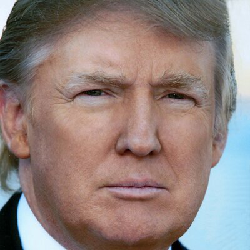

In [32]:
img = array_to_img(trump)
display(img)